# 5.3 階層ベイズモデル - 第5章ベイズ推論プログラミング
## はじめに
[Pythonでスラスラわかる ベイズ推論「超」入門(赤石 雅典 (著), 須山 敦志 (監修))](https://www.yodobashi.com/product/100000009003770765/)の5.3節のPyMCコードをNumPyroで書き直しました。\
アイリス・データセットの3種類の花のデータを3個ずつ抽出しました。\
合計9個のデータで3種類の花のがく片の長さ```sepal_length```とがく片の幅```sepal_width```の1次関数近似のベイズ推論を行います。\
関連するデータが少しずつあるという業務でありがちな状況でベイズ推論が輝きます。

## フォルダ構造とユーティリティ関数、ライブラリimport
リンク集の記事にフォルダ構造とユーティリティ関数、ライブラリimportを掲載しました。\
準備としてそちらのページをご覧ください。
1. [フォルダ構造とユーティリティ関数](https://zenn.dev/tremendous1192/articles/eacc2b67d911db#%E3%83%95%E3%82%A9%E3%83%AB%E3%83%80%E6%A7%8B%E9%80%A0%E3%81%A8%E3%83%A6%E3%83%BC%E3%83%86%E3%82%A3%E3%83%AA%E3%83%86%E3%82%A3%E9%96%A2%E6%95%B0)
1. [ライブラリimport](https://zenn.dev/tremendous1192/articles/eacc2b67d911db#%E9%96%A2%E9%80%A3notebook%E3%81%AE%E5%85%B1%E9%80%9Aimport)

## モジュールのimport

In [1]:
# Module
import sys
sys.path.append("../")
from mod.numpyro_utility import *

# DataFrame, Numerical computation
import polars as pl
pl.Config(fmt_str_lengths = 100, tbl_cols = 100, tbl_rows = 100)
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

# ベイズ推定
import numpyro
import numpyro.distributions as dist # 確率分布

# plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

# plotの設定
import json
def to_rc_dict(dict):
    """
    jsonファイルのdictを読み込む
    """
    return {f'{k1}.{k2}': v for k1,d in dict.items() for k2,v in d.items()}

file_path = "../mod/rcParams.json"
with open(file_path) as f: 
    plt.rcParams.update(to_rc_dict(json.load(f)))

# 日本語 or 英語の2択
import japanize_matplotlib
#plt.rcParams['font.family'] = "Times New Roman"

## 5.3 階層ベイズモデル

### 5.3.1 問題設定
3種類の花から3つずつデータを抽出して、がく片の長さと幅の1次関数近似を行います。

### 5.3.2 データ準備
問題設定の通りにデータを抽出します。

In [2]:
# データセットを読み込む
df = sns.load_dataset("iris")

# setosa を抽出する
df_setosa = df.query('species == "setosa"')
df_versicolor = df.query('species == "versicolor"')
df_virginica = df.query('species == "virginica"')

# 乱数により3個のインデックスを生成
import random
random.seed(42)
indexes =range(len(df_setosa))
sample_indexes=random.sample(indexes, 3)

# df0, df1, df2のデータ数をそれぞれ3行にする
df_setosa_sel = df_setosa.iloc[sample_indexes]
df_versicolor_sel = df_versicolor.iloc[sample_indexes]
df_virginica_sel = df_virginica.iloc[sample_indexes]

#　全部連結して一つにする
df_sel = pd.concat([df_setosa_sel, df_versicolor_sel, df_virginica_sel]).reset_index(drop=True)

# 加工結果の確認
display(df_sel)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.0,3.5,1.3,0.3,setosa
1,5.0,3.4,1.5,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,5.5,2.6,4.4,1.2,versicolor
4,4.9,2.4,3.3,1.0,versicolor
5,6.4,3.2,4.5,1.5,versicolor
6,6.7,3.1,5.6,2.4,virginica
7,7.3,2.9,6.3,1.8,virginica
8,5.8,2.7,5.1,1.9,virginica


抽出したデータの散布図をプロットします。\
versicolorとvirginicaは1次関数近似できそうですが、setosaはデータが集中しすぎて1次関数近似が難しそうです。

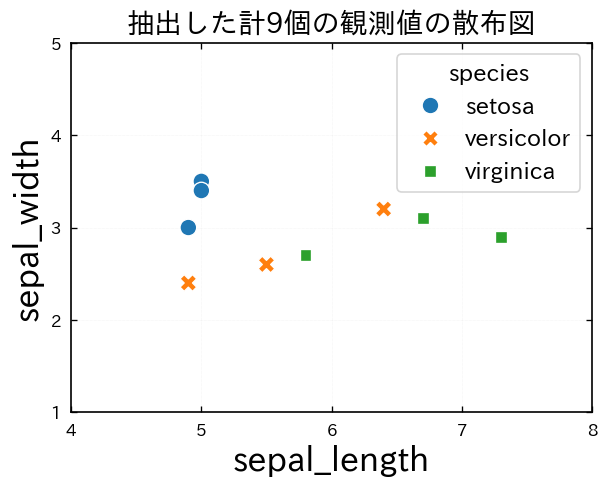

In [3]:
sns.scatterplot(
    x='sepal_length', y='sepal_width', hue='species', style='species',
    data=df_sel, s=100)
plt.xticks([4, 5, 6, 7, 8])
plt.yticks([1, 2, 3, 4, 5])
plt.title('抽出した計9個の観測値の散布図');

In [4]:
X = jnp.array(df_sel['sepal_length'].values, dtype = float)
Y = jnp.array(df_sel['sepal_width'].values, dtype = float)
species = df_sel['species']
cl = jnp.array(pd.Categorical(species).codes, dtype = int)

# 結果確認
print(X)
print(Y)
print(species.values)
print(cl)

[5.  5.  4.9 5.5 4.9 6.4 6.7 7.3 5.8]
[3.5 3.4 3.  2.6 2.4 3.2 3.1 2.9 2.7]
['setosa' 'setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor'
 'virginica' 'virginica' 'virginica']
[0 0 0 1 1 1 2 2 2]


### 5.3.3 確率モデル定義
確率モデルをプログラミングするために、前章と同様に数式を使って状況を整理します。

まず、散布図より $N$ 組の ```sepal_length``` $x_{i}$ とがく片の幅 ```sepal_width``` $y_{i}$ は1次関数で近似できると仮定します。\
このとき1次関数の切片と傾きは花の種類の序数 $s$ 毎に異なる値を取ると仮定します。

$$
y_{i} \approx \omega_{0, s} + \omega_{1, s} x_{i}
$$

ただでさえデータが少ないのにさらに分割するのは不安ですが先に進めます。\
確率モデルを作成するためのテクニックとして、右辺を $\mu_{i}$ とおくことにします。

$$
\mu_{i} \equiv \omega_{0, s} + \omega_{1, s} x_{i}\\
\Rightarrow y_{i} \approx \mu_{i}
$$

$y_{i}$ は $x_{i}$ の値に応じた定数 $\mu_{i}$ に近い値を取ると読むことができます。\
5.1節の正規分布の仮定とほぼ同じですね。\
$y_{i}$ が $x_{i}$ の値に応じた平均値 $\mu_{i}$ をパラメータに持つ正規分布に従うと仮定します。

$$
y_{i} \sim N(\mu_{i}, \sigma^2)
$$

1次関数近似のベイズ推論は、1次関数のパラメータ $\{ \omega_{0, s}, \omega_{1, s} \}$ と正規分布の標準偏差 $\sigma$ を求める問題になりました。\
階層ベイズはさらにもう一段階の確率分布の仮定をおきます。\
1次関数のパラメータ $\{ \omega_{0, s}, \omega_{1, s} \}$ はそれぞれが花の種類ごとの平均と標準偏差を持つ正規分布に従うと仮定します。

$$
\begin{aligned}
\omega_{0, s} \sim& N(\mu_{\omega_{0}, s}, \sigma_{\omega_{0}, s}^2)\\
\mu_{\omega_{0}, s} \sim& N(0,10^2)\\
\sigma_{\omega_{0}, s} \sim& HN(10^2)\\
\omega_{1, s} \sim& N(\mu_{\omega_{1}, s}, \sigma_{\omega_{1}, s}^2)\\
\mu_{\omega_{1}, s} \sim& N(0,10^2)\\
\sigma_{\omega_{1}, s} \sim& HN(10^2)
\end{aligned}
$$


標準偏差 $\sigma$ は標準偏差10の半正規分布に従うと仮定します。

$$
\begin{aligned}
\sigma \sim& HN(0,10^2)
\end{aligned}
$$

ここまで複雑だと数式がごちゃごちゃするので、一気にプログラミングを行います。\
ここまでの仮定を、後ろの方から記述します。

In [5]:
def model_hierarchical_bayes(X, Y = None, cl = None, n_groups = None):
    '''
        5.3節の3種類の花の1次関数近似の階層ベイズモデル
    '''
    # 1次関数のパラメータ $\{ \omega_{0, s}, \omega_{1, s} \}$ はそれぞれが花の種類ごとの平均と標準偏差を持つ正規分布に従うと仮定します
    μ_ω0 = numpyro.sample("μ_ω0", dist.Normal(loc = 0, scale = 10))
    σ_ω0 = numpyro.sample("σ_ω0", dist.HalfNormal(scale = 10))
    # ベクトル化(階層ベイズの花の種類の数を確率変数に割り当てるためのNumPyroのお作法)
    with numpyro.plate("group", n_groups):
        ω0 = numpyro.sample("ω0", dist.Normal(loc = μ_ω0, scale = σ_ω0))
    # 傾きも切片と同様にモデルを定義する
    μ_ω1 = numpyro.sample("μ_ω1", dist.Normal(loc = 0, scale = 10))
    σ_ω1 = numpyro.sample("σ_ω1", dist.HalfNormal(scale = 10))
    with numpyro.plate("group", n_groups):
        ω1 = numpyro.sample("ω1", dist.Normal(loc = μ_ω1, scale = σ_ω1))
    # 1次関数の右辺を $\mu_{i}$ とおきます
    μ = numpyro.deterministic("μ", ω0[cl] + ω1[cl] * X)
    # 正規分布の標準偏差は標準偏差10の半正規分布に従うと仮定します
    σ = numpyro.sample("σ", dist.HalfNormal(scale = 10))
    # 目的変数 y は説明変数 x の値に応じた平均値 μ をパラメータとする正規分布に従うと仮定します。
    # ベクトル化(学習用データを確率変数に割り当てるためのNumPyroのお作法)
    N = len(X)
    with numpyro.plate("N", N):
        numpyro.sample("Y", dist.Normal(loc = μ, scale = σ), obs = Y)

作成したﾓﾃﾞﾙをプロットします。\
1次関数の確率分布にさらにもう一段階上の確率分布を仮定するのが階層ベイズモデルです。

Model graph saved to: 階層ベイズ.svg


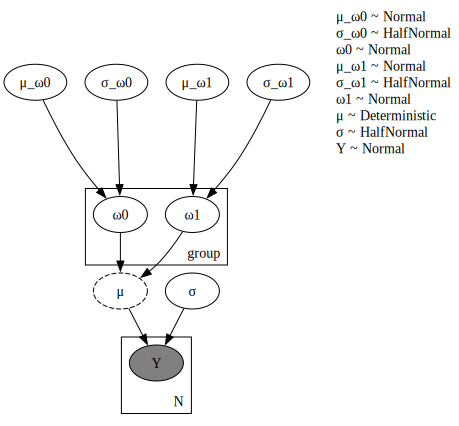

'階層ベイズ.svg'

In [6]:
model_args = {
    "X": X,
    "Y": Y,
    "cl": cl,
    "n_groups": len(species.unique())
}
try_render_model(model_hierarchical_bayes, render_name = "階層ベイズ", **model_args)

### 5.3.4 サンプリングと結果分析
データを用意してモデルを作成したら後はユーティリティ関数に渡すだけです。

In [7]:
model_args = {
    "X": X,
    "Y": Y,
    "cl": cl,
    "n_groups": len(species.unique())
}
idata = run_mcmc(
    model_hierarchical_bayes,
    num_chains = 4,
    num_warmup = 1000,
    num_samples = 1000,
    thinning = 1,
    seed = 42,
    target_accept_prob = 0.8,
    log_likelihood = False,
    **model_args
)

sample: 100%|██████████| 2000/2000 [00:06<00:00, 324.09it/s, 127 steps of size 2.18e-02. acc. prob=0.93]


結果分析のコードは書籍とほぼ同じです。

まずはサンプリングが上手くいったか確認します。

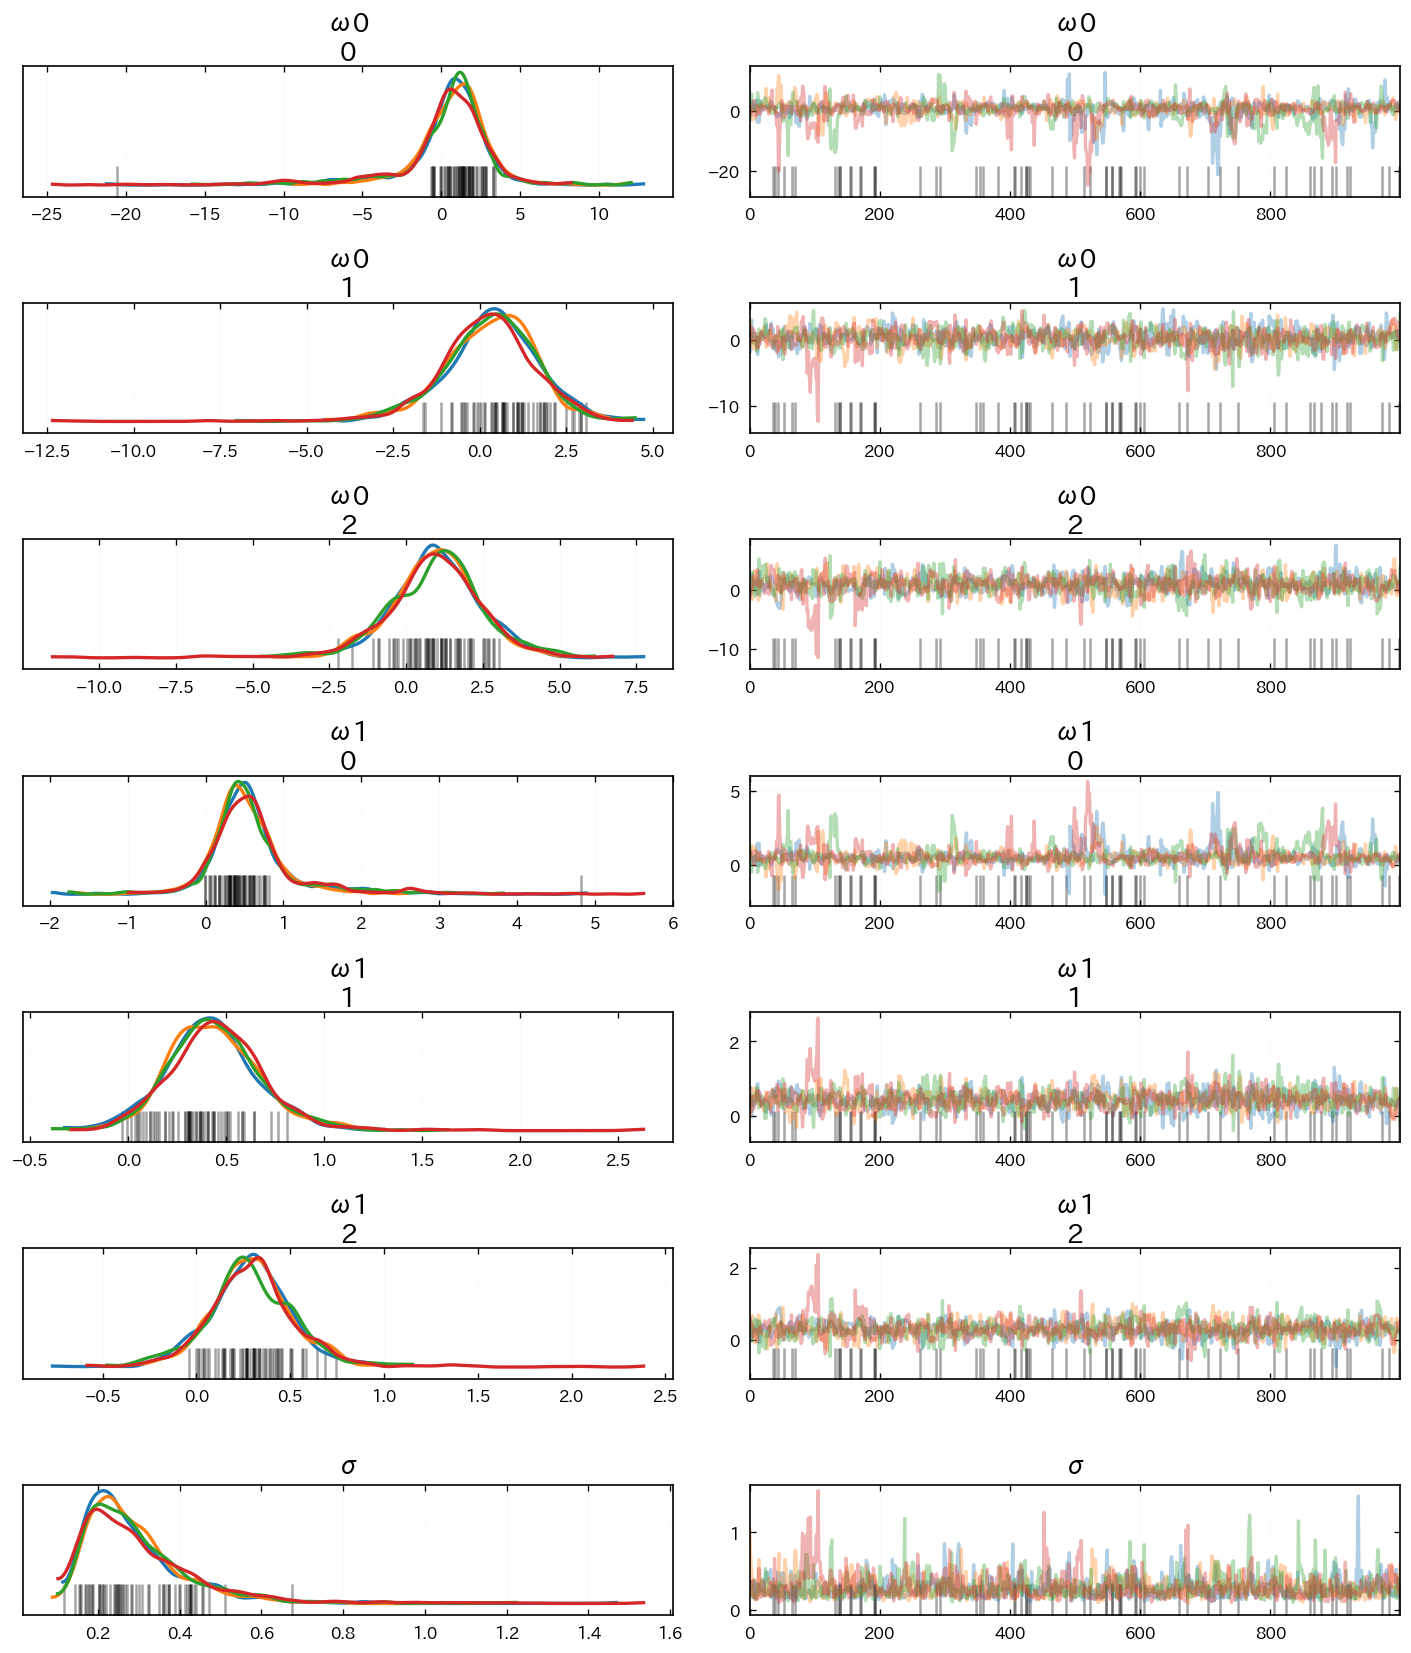

In [8]:
az.plot_trace(idata, compact = False, var_names = ["ω0", "ω1", "σ"])
plt.tight_layout()

知りたかった1次関数の切片と傾きの事後分布をプロットします。

In [9]:
summary = az.summary(idata, var_names = ["ω0", "ω1"])
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ω0[0],0.373,2.978,-5.869,4.892,0.131,0.222,703.0,494.0,1.01
ω0[1],0.290,1.373,-2.237,2.845,0.047,0.066,856.0,1045.0,1.00
ω0[2],0.961,1.549,-1.889,3.791,0.055,0.090,930.0,816.0,1.00
ω1[0],0.588,0.600,-0.362,1.792,0.026,0.045,707.0,506.0,1.01
ω1[1],0.438,0.244,-0.030,0.874,0.008,0.012,867.0,1018.0,1.00
ω1[2],0.294,0.235,-0.146,0.720,0.008,0.014,930.0,796.0,1.00


### 5.3.5 散布図と回帰直線の重ね描き
花の種類ごとの1次関数近似の直線と答えの散布図をプロットします。\
たった9個のデータから計算したとは思えない精度です。

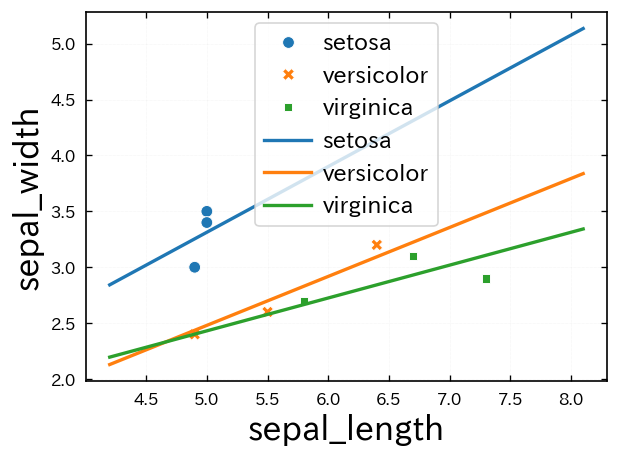

In [10]:
# alphaとbetaの平均値の導出
means = summary['mean']
ω0_0 = means['ω0[0]']
ω0_1 = means['ω0[1]']
ω0_2 = means['ω0[2]']
ω1_0 = means['ω1[0]']
ω1_1 = means['ω1[1]']
ω1_2 = means['ω1[2]']

# 回帰直線用座標値の計算
x_range = np.array([df['sepal_length'].min()-0.1, df['sepal_length'].max()+0.1+0.1])
y0_range = ω1_0 * x_range + ω0_0
y1_range = ω1_1 * x_range + ω0_1
y2_range = ω1_2 * x_range + ω0_2

# 散布図表示
sns.scatterplot(
    x='sepal_length', y='sepal_width', hue='species', style='species',
    data=df_sel, s=50)
plt.plot(x_range, y0_range, label='setosa')
plt.plot(x_range, y1_range, label='versicolor')
plt.plot(x_range, y2_range, label='virginica')
plt.legend();

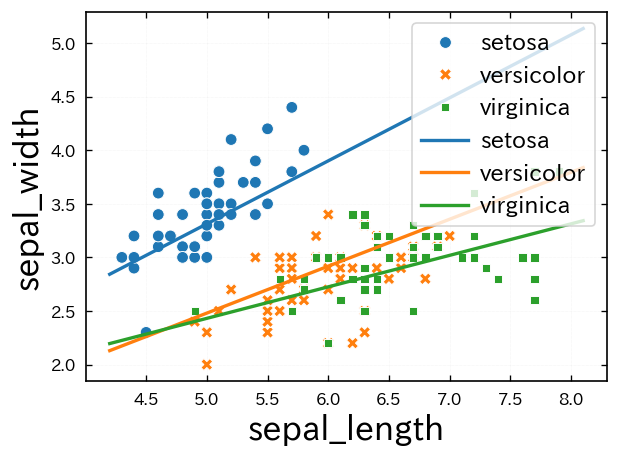

In [11]:
# 散布図表示
sns.scatterplot(
    x='sepal_length', y='sepal_width', hue='species', style='species',
    data=df, s=50)
plt.plot(x_range, y0_range, label='setosa')
plt.plot(x_range, y1_range, label='versicolor')
plt.plot(x_range, y2_range, label='virginica')
plt.legend();

## 終わりに
階層ベイズモデルのベイズ推論を行いました。\
関連するデータが少しずつあるという業務でありがちな状況でベイズ推論が輝くことが分かりました。